## Tensorboard

In [1]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [3]:
! del /q %TMP%\.tensorboard-info\*

The system cannot find the file specified.


In [2]:
%tensorboard --logdir logs/scalars --host localhost

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
%matplotlib notebook
import sklearn
import skimage
from sklearn import svm, metrics, datasets
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV, train_test_split
from scipy import ndimage, misc

import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
from skimage.transform import resize
import pylab
import pydicom as pyd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image

import cv2

Using TensorFlow backend.


In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("physical_devices-------------", len(physical_devices))
# tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
def dcmchange(orig,clahe,feature) :
    r,c = orig.shape
    new = np.empty((r,c,3), dtype=orig.dtype)
#     new[:,:,:] = orig[:,:,np.newaxis]
    new[:,:,0] = orig[:,:]
    new[:,:,1] = clahe[:,:]
    new[:,:,2] = feature[:,:]
    return new

In [3]:
from skimage import measure, morphology, segmentation
from skimage import exposure
def marker(img):
    h,w = img.shape[:2]
    for row in range(h):
        if img[row, 0] == 1:
            cv2.floodFill(img, None, (0, row), 0)
        if img[row, w-1] == 1:
            cv2.floodFill(img, None, (w-1, row), 0)
    for col in range(w):
        if img[0, col] == 1:
            cv2.floodFill(img, None, (col, 0), 0)
        if img[h-1, col] == 1:
            cv2.floodFill(img, None, (col, h-1), 0)
    holes = img.copy()
    cv2.floodFill(holes, None, (0,0), 1)
    holes = cv2.bitwise_not(holes)
    mask = cv2.bitwise_or(img, holes)
    mask_img = cv2.bitwise_and(img, img, mask=mask)
    return mask_img

## Read Data

In [13]:
p = Path("./dataset/")
dirs = p.glob("*")
labels_dict = {'CA lung':0, 'Extra':0, 'Heart and TGV':0, 'Abnormal': 0,
               'Intra': 0, 'No Finding': 1, 'TB': 0, 'Pneumonia' : 0}
count = 0

disease_images = []
normal_images = []
disease_labels = []
normal_labels = []

count_normal = 0
count_disease = 0

for folder_dir in dirs:
    label = str(folder_dir).split("/")[-1][:-1]
#     print(label)
#     print(folder_dir)
    if label == 'Abnormal' or label == 'No Finding' :
        for img_path in folder_dir.glob("*.dcm"):
#             print(img_path)
#             pic = pyd.read_file(os.path.normpath(img_path))
            target = "./" + str(img_path)
#             print(target)
            pic = pyd.read_file(target)
    #         pic_dir.append(pic)
            pic_r = np.array(pic.pixel_array)
    #         print(pic_r.shape)
            %matplotlib inline 
    #         preprocessing
            clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
            pic_r1 = clahe.apply(pic_r)
            
#             mark = marker(pic_r)
#             plt.imshow(mark)
#             print(mark.shape)
    #         preprocessing
            IMG_PX_SIZE = 224
            resized_org = resize(pic_r, (IMG_PX_SIZE, IMG_PX_SIZE), anti_aliasing=True)
            resized_clahe = resize(pic_r1, (IMG_PX_SIZE, IMG_PX_SIZE), anti_aliasing=True)
            resized_equal = exposure.equalize_adapthist(resized_org, clip_limit=0.03)
            #change pic to (224,224,3)
            resized_img = dcmchange(resized_org,resized_clahe,resized_equal)
            resized_img2 = exposure.equalize_adapthist(resized_img, clip_limit=0.03)
            if label == 'Abnormal':
                disease_images.append(resized_img2)
                disease_labels.append(labels_dict[label])
#                 heart_images.append(ndimage.rotate(resized_img2, 1, reshape=False))
                count_disease+=1
            elif label == 'No Finding':
                normal_images.append(resized_img2)
                normal_labels.append(labels_dict[label])
                count_normal+=1

            if count_normal == 1000 or count_disease == 1000 : 
                break

        count_normal = 0
        count_disease = 0


/usr/local/lib/python3.5/dist-packages/skimage/color/colorconv.py:271: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = (arr[idx, 1] - arr[idx, 2]) / delta[idx]
/usr/local/lib/python3.5/dist-packages/skimage/color/colorconv.py:279: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 4. + (arr[idx, 0] - arr[idx, 1]) / delta[idx]
/usr/local/lib/python3.5/dist-packages/skimage/color/colorconv.py:265: RuntimeWarning: divide by zero encountered in true_divide
  out_s = delta / out_v


## Test/Train

In [14]:
disease_images = np.array(disease_images, dtype=np.float32) #heart_images
disease_labels = np.array(disease_labels)
normal_images = np.array(normal_images, dtype=np.float32) #normal_images
normal_labels = np.array(normal_labels)

In [15]:
print("number of sample Heart: {}".format(len(disease_images)))
print("number of sample No Finding: {}".format(len(normal_images)))

number of sample Heart: 1000
number of sample No Finding: 1000


In [16]:
disease_images[1].shape

(224, 224, 3)

In [17]:
np.max(disease_images[400])

1.0

In [4]:
plt.imshow(disease_images[1])

NameError: name 'disease_images' is not defined

In [10]:
img = exposure.equalize_adapthist(disease_images[1], clip_limit=0.03)

/usr/local/lib/python3.5/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.5/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to float32
  .format(dtypeobj_in, dtypeobj_out))


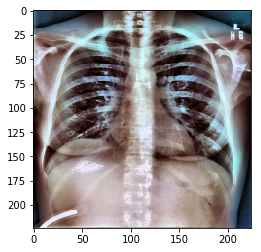

In [11]:
plt.imshow(img)

In [30]:
flip = cv2.flip(img, 1)

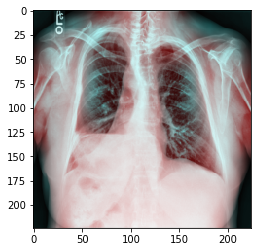

In [31]:
plt.imshow(flip)

## Feature

In [19]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from datetime import datetime
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc

# from tensorflow.keras.applications import VGG16

## Model

In [41]:
def cnn_model(X_train,y_train,X_test,y_test,X_val,y_val,r,text) :
    
    tf.keras.backend.clear_session()
    
    #tensorboard
    logdir = "logs\\scalars\\" + str(text) + "-Fold" + str(r) + "-" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
    
    INIT_LR = 3e-3
    EPOCHS = 20
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

    vgg_model = VGG16(weights="imagenet", 
                             include_top= False,
                             input_tensor=Input(shape=(224, 224,3)))
    
    for layer in vgg_model.layers:
        layer.trainable = False
        
    new_model = vgg_model.output
    new_model = AveragePooling2D(pool_size=(7, 7))(new_model)
    new_model = Flatten(name="flatten")(new_model)
    new_model = Dense(256, activation="relu")(new_model)
    new_model = Dropout(0.4)(new_model)
    new_model = Dense(2, activation="softmax")(new_model)
    model = Model(inputs=vgg_model.input, outputs=new_model)
    
#     model.summary()

    model.compile(optimizer=opt,
#               loss='categorical_crossentropy',
                loss='binary_crossentropy',
              metrics=['accuracy'])
#     with tf.device("/device:GPU:0"):
    history = model.fit(
        X_train, # input
        y_train, # output
        batch_size=128,
        verbose=0, # Suppress chatty output; use Tensorboard instead
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
#         callbacks=[tensorboard_callback],
    )
    print("Average test accuracy: ", np.average(history.history['accuracy']))
    print("Average test loss: ", np.average(history.history['loss']))
    
    %matplotlib inline 
    
    plt.figure()
    plt.plot(history.history['accuracy'], 'orange', label='Training accuracy')
    plt.plot(history.history['val_accuracy'], 'blue', label='Validation accuracy')
    plt.plot(history.history['loss'], 'red', label='Training loss')
    plt.plot(history.history['val_loss'], 'green', label='Validation loss')
    plt.legend()
    plt.show()
    
    y_pred = model.predict(X_val)
#     y_roc = model.predict(X_val)
#     y_pred_classes = np.argmax(y_pred,axis = 1)
#     print(y_pred)
    
    #confusion
    confusion(y_val,y_pred)
#     y_score = history.predict(X_test)
#     y_score = history.predict_proba(X_val)[:, 1]
#     print(y_score)

    #roc
    fpr, tpr, thresholds = roc_curve(y_val[:,1], y_pred[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    
    #save model
    model.save('model\\abnormal\\vgg16\\'+str(text)+'_'+str(r))
    
    return fpr,tpr,roc_auc

In [40]:
from tensorflow.keras.applications import VGG19
def vgg19_model(X_train,y_train,X_test,y_test,X_val,y_val,r,text) :
    
    tf.keras.backend.clear_session()
    
    #tensorboard
    logdir = "logs\\scalars\\" + str(text) + "-Fold" + str(r) + "-" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
    
    INIT_LR = 3e-3
    EPOCHS = 20
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    
    vgg19_model = VGG19(weights="imagenet", 
                             include_top= False,
                             input_tensor=Input(shape=(224, 224,3)))
    
    for layer in vgg19_model.layers:
        layer.trainable = False
        
    new_model = vgg19_model.output
    new_model = AveragePooling2D(pool_size=(7, 7))(new_model)
    new_model = Flatten(name="flatten")(new_model)
    new_model = Dense(256, activation="relu")(new_model)
    new_model = Dropout(0.4)(new_model)
    new_model = Dense(2, activation="softmax")(new_model)
    model = Model(inputs=vgg19_model.input, outputs=new_model)
    
#     model.summary()

    model.compile(optimizer=opt,
#               loss='categorical_crossentropy',
                loss='binary_crossentropy',
              metrics=['accuracy'])
#     with tf.device("/device:GPU:0"):
    history = model.fit(
        X_train, # input
        y_train, # output
        batch_size=128,
        verbose=0, # Suppress chatty output; use Tensorboard instead
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
#         callbacks=[tensorboard_callback],
    )
    print("Average test accuracy: ", np.average(history.history['accuracy']))
    print("Average test loss: ", np.average(history.history['loss']))
    
    %matplotlib inline 
    
    plt.figure()
    plt.plot(history.history['accuracy'], 'orange', label='Training accuracy')
    plt.plot(history.history['val_accuracy'], 'blue', label='Validation accuracy')
    plt.plot(history.history['loss'], 'red', label='Training loss')
    plt.plot(history.history['val_loss'], 'green', label='Validation loss')
    plt.legend()
    plt.show()
    
    y_pred = model.predict(X_val)
#     y_pred_classes = np.argmax(y_pred,axis = 1)
#     print(y_pred)
    #confusion
    confusion(y_val,y_pred)
#     y_score = history.predict(X_test)
#     y_score = model.predict_proba(X_test)[:, 1] 

    #roc
    fpr, tpr, thresholds = roc_curve(y_val[:,1], y_pred[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    
    #save model
    model.save('model/abnormal/vgg19/'+str(text)+'_'+str(r))
    
    return fpr,tpr,roc_auc

## Confusion Matrix

In [22]:
import seaborn as sns
from sklearn.metrics import classification_report 
def confusion(y_test,pred) :
    cm_plot_labels = ['Finding', 'Normal']
    #Confusion Matrix
    %matplotlib inline 

    confusion_mat1 = confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1))
    confusion_mat1 = confusion_mat1.astype('float') / confusion_mat1.sum(axis=1)[:, np.newaxis]
    
#     plot_confusion_matrix(confusion_mat1, cm_plot_labels, title='Confusion Matrix')
    sns.heatmap(confusion_mat1, annot=True, fmt=".2f")
    plt.show()
    
    print(classification_report(y_test.argmax(axis=1), pred.argmax(axis=1), target_names=cm_plot_labels))
    

## ROC

In [23]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc

In [24]:
def roc(fpr_recv,tpr_recv,acc_recv,num) :

    color = ["orange","green","blue","red","purple"]
    for i in range(num):
        fpr_use = fpr_recv[i]
        tpr_use = tpr_recv[i]
        acc_use = acc_recv[i]
#         print(len(fpr_use))
#         auc = roc_auc_score(y_val_rec, roc_pred)
#         print('AUC Fold %d: %0.4f' %(i,auc))
        
        plt.plot(fpr_use, tpr_use, color='{}'.format(color[i]), label='AUC Fold %d: %0.4f' %(i,acc_use))
        plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    std_auc = np.std(acc_recv)
    tprs = []
#     auc = []
    mean_fpr = np.linspace(0, 1, 100)
    for i in range(num):
        tprs.append(np.interp(mean_fpr, fpr_recv[i], tpr_recv[i]))
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    print(type(mean_fpr))
    print(type(mean_tpr))
    mean_auc = auc(mean_fpr, mean_tpr)
    
    plt.plot(mean_fpr, mean_tpr, color='black', 
             label='AUC Fold Average: %0.4f $\pm$ %0.2f' %(mean_auc, std_auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

## Run

In [25]:
def AllinOne(other, normal,text) :
    stck_prob = []
    dis = 0
    #Set Test
    X_test = []
    y_test = []
    other_img = []
    normal_img = []
    for i in range(len(normal)) :
        if i >= 8 * len(normal) / 10 :
            X_test.append(normal[i])
            y_test.append(1)
        else :
            normal_img.append(normal[i])
    for i in range(len(other)) :
        if i >= 8 * len(other) / 10 :
            X_test.append(other[i])
            y_test.append(0)
        else :
            other_img.append(other[i])
    #Set Data
    for k in range(5):
        X_train = []
        y_train = []
        X_val = []
        y_val = []
#         print(dis)
#         print(((8-dis) * len(normal)),((10-dis) * len(normal)))
        for i in range(len(normal_img)) :
            if i >= (8-dis) * len(normal_img) / 10 and i < (10-dis) * len(normal_img) / 10  :
                X_val.append(normal_img[i])
                y_val.append(1)
            else :
                X_train.append(normal_img[i])
                y_train.append(1)
        for i in range(len(other_img)) :
            if i >= (8-dis) * len(other_img) / 10 and i < (10-dis) * len(other_img) / 10  :
                X_val.append(other_img[i])
                y_val.append(0)
            else :
                X_train.append(other_img[i])
                y_train.append(0)
        #add dis
        dis = dis + 2
        #data
        y_train_s = np.array(y_train)
        X_train_s = np.array(X_train, dtype=np.float32) #train_images
        y_test_s = np.array(y_test)
        X_test_s = np.array(X_test, dtype=np.float32) #test_images
        y_val_s = np.array(y_val)
        X_val_s = np.array(X_val, dtype=np.float32) #val_images
        
        print("number of sample Train: {}".format(len(X_train_s)))
        print("number of sample Test: {}".format(len(X_test_s)))
        print("number of sample Val: {}".format(len(X_val_s)))
        
        #change dicom to (224,224,3)
        
        
        #class
        n_classes = 2
        y_train_n = keras.utils.to_categorical(y_train_s, n_classes)
        y_test_n = keras.utils.to_categorical(y_test_s, n_classes)
        y_val_n = keras.utils.to_categorical(y_val_s, n_classes)
        # Feature
#         X_train_n,X_test_n = scaling(X_train_s,X_test_s)
        # run model
        probs = dense_model(X_train_s,y_train_n,X_test_s,y_test_n,X_val_s,y_val_n,k,text)    
#         print(y_test_n.shape)
#         print(probs.shape)
#         fpr, tpr, thresholds = roc_curve(y_test_n[:,0], probs[:,0])
#         roc_auc = metrics.auc(fpr, tpr)
#         print(roc_auc)
        # confusion
        stck_prob.append(probs)
    # ROC
    roc(y_test_n,stck_prob)

## Increase

In [26]:
def incre(data,labels):
    new_data = []
    new_label = []
    for i in range(data.shape[0]):
        new_data.append(data[i])
        new_data.append(ndimage.rotate(data[i], 15, reshape=False))
        new_data.append(ndimage.rotate(data[i], -15, reshape=False))
        new_data.append(cv2.flip(data[i], 1))
        new_label.append(labels[i])
        new_label.append(labels[i])
        new_label.append(labels[i])
        new_label.append(labels[i])
    new_data = np.array(new_data)
    new_label = np.array(new_label)
    return new_data,new_label

## Abnormal

In [27]:
from sklearn.model_selection import KFold
def idk(other, normal,text) :
    k = 0
    # set to 5 folds
    box_tpr = []
    box_fpr = []
    box_acc = []
    #Set Test
    data = []
    label = []
    index = 0
    for i in range(5):
        for count in range(int(normal.shape[0]/5)):
            data.append(normal[index+count])
            label.append(1)
#             print(index+count)
        for count in range(int(other.shape[0]/5)):
            data.append(other[index+count])
            label.append(0)
        index+=int(normal.shape[0]/5)
    data = np.array(data)
    label = np.array(label)
    train_data, X_test, label_train, y_test = train_test_split(data, label, test_size=0.2)
#     X_test_n, y_test_n = incre(X_test,y_test)
    n_classes = 2
    y_test = keras.utils.to_categorical(y_test, n_classes)
    kf = KFold(n_splits=5)
    for train, val in kf.split(train_data):
        X_train = train_data[train]
        X_val = train_data[val]
        y_train = label_train[train]
        y_val = label_train[val]
        
#         X_train_n, y_train_n = incre(X_train,y_train)
#         X_val_n, y_val_n = incre(X_val,y_val)
        #class
        y_train = keras.utils.to_categorical(y_train, n_classes)
        y_val = keras.utils.to_categorical(y_val, n_classes)
#         print(y_test)
        
        print("number of sample Train: {}".format(len(X_train)))
        print("number of sample Test: {}".format(len(X_test)))
        print("number of sample Val: {}".format(len(X_val)))
        
        
        recv_fpr,recv_tpr,recv_acc = vgg19_model(X_train,y_train,X_test,y_test,X_val,y_val,k,text)
        box_fpr.append(recv_fpr)
        box_tpr.append(recv_tpr)
        box_acc.append(recv_acc)
        k += 1
        
        #only one round
#         if k == 1: break
        
    # ROC
    roc(box_fpr,box_tpr,box_acc,k)

## Mark Temp VGG19

number of sample Train: 1280
number of sample Test: 400
number of sample Val: 320
Average test accuracy:  0.57562506
Average test loss:  0.692536233663559


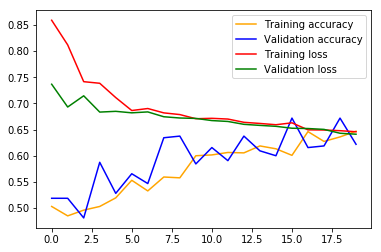

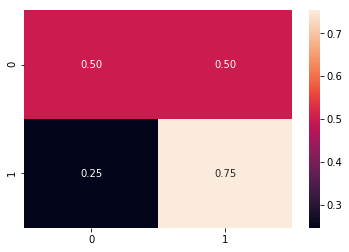

             precision    recall  f1-score   support

    Finding       0.69      0.50      0.58       166
     Normal       0.58      0.75      0.66       154

avg / total       0.64      0.62      0.62       320

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model/abnormal/vgg19/AbNormal_0/assets
number of sample Train: 1280
number of sample Test: 400
number of sample Val: 320
Average test accuracy:  0.5880469
Average test loss:  0.679830361008644


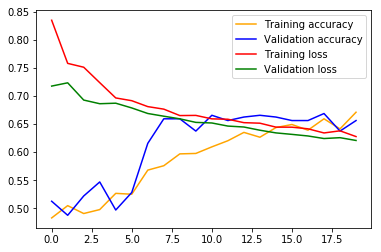

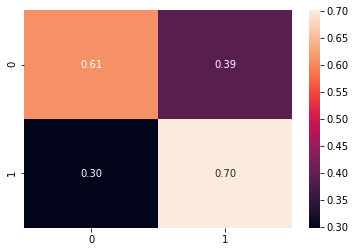

             precision    recall  f1-score   support

    Finding       0.66      0.61      0.63       156
     Normal       0.65      0.70      0.68       164

avg / total       0.66      0.66      0.66       320

INFO:tensorflow:Assets written to: model/abnormal/vgg19/AbNormal_1/assets
number of sample Train: 1280
number of sample Test: 400
number of sample Val: 320
Average test accuracy:  0.5853906
Average test loss:  0.6819804799556732


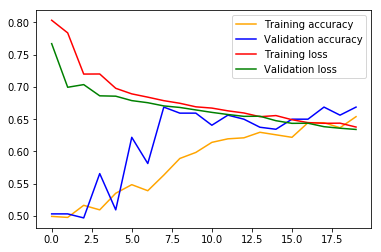

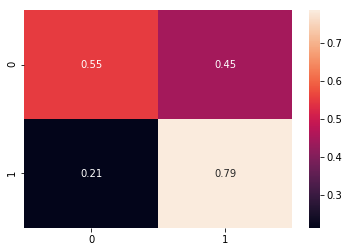

             precision    recall  f1-score   support

    Finding       0.72      0.55      0.63       161
     Normal       0.63      0.79      0.70       159

avg / total       0.68      0.67      0.66       320

INFO:tensorflow:Assets written to: model/abnormal/vgg19/AbNormal_2/assets
number of sample Train: 1280
number of sample Test: 400
number of sample Val: 320
Average test accuracy:  0.61574215
Average test loss:  0.6513827335834503


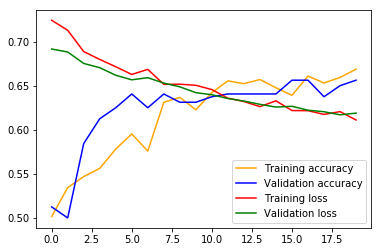

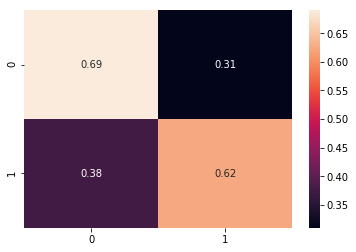

             precision    recall  f1-score   support

    Finding       0.64      0.69      0.66       158
     Normal       0.67      0.62      0.65       162

avg / total       0.66      0.66      0.66       320

INFO:tensorflow:Assets written to: model/abnormal/vgg19/AbNormal_3/assets
number of sample Train: 1280
number of sample Test: 400
number of sample Val: 320
Average test accuracy:  0.6020704
Average test loss:  0.6756488996744154


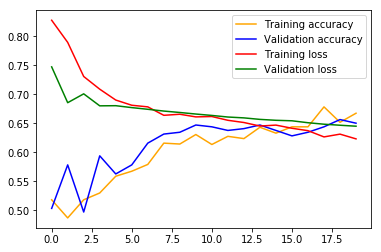

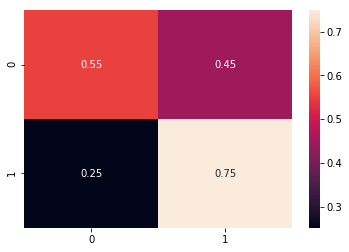

             precision    recall  f1-score   support

    Finding       0.69      0.55      0.61       161
     Normal       0.62      0.75      0.68       159

avg / total       0.66      0.65      0.65       320

INFO:tensorflow:Assets written to: model/abnormal/vgg19/AbNormal_4/assets


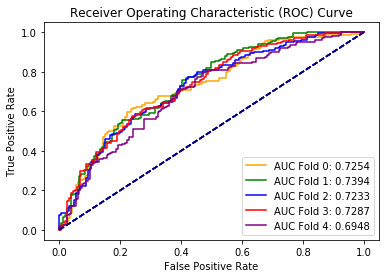

In [28]:
idk(disease_images, normal_images,"AbNormal")

number of sample Train: 1280
number of sample Test: 400
number of sample Val: 320
Average test accuracy:  0.64070314
Average test loss:  0.6322072553634643


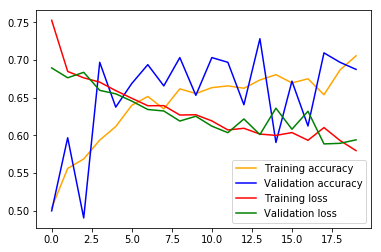

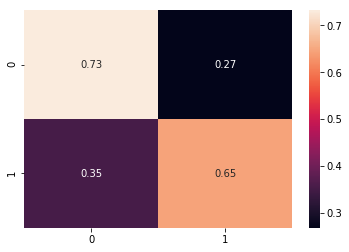

             precision    recall  f1-score   support

    Finding       0.65      0.73      0.69       153
     Normal       0.72      0.65      0.68       167

avg / total       0.69      0.69      0.69       320

INFO:tensorflow:Assets written to: model/abnormal/vgg19/AbNormal_0/assets
number of sample Train: 1280
number of sample Test: 400
number of sample Val: 320
Average test accuracy:  0.6243359
Average test loss:  0.6533393353223802


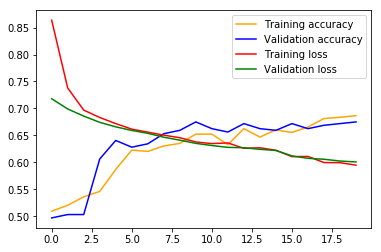

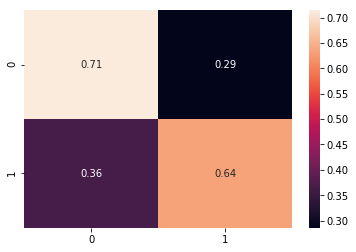

             precision    recall  f1-score   support

    Finding       0.66      0.71      0.69       161
     Normal       0.69      0.64      0.66       159

avg / total       0.68      0.68      0.67       320

INFO:tensorflow:Assets written to: model/abnormal/vgg19/AbNormal_1/assets
number of sample Train: 1280
number of sample Test: 400
number of sample Val: 320
Average test accuracy:  0.6399609
Average test loss:  0.6381623703241348


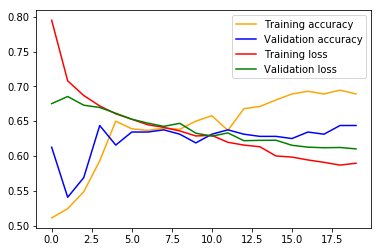

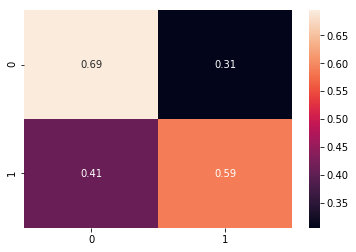

             precision    recall  f1-score   support

    Finding       0.65      0.69      0.67       167
     Normal       0.64      0.59      0.61       153

avg / total       0.64      0.64      0.64       320

INFO:tensorflow:Assets written to: model/abnormal/vgg19/AbNormal_2/assets
number of sample Train: 1280
number of sample Test: 400
number of sample Val: 320
Average test accuracy:  0.6223438
Average test loss:  0.652229556441307


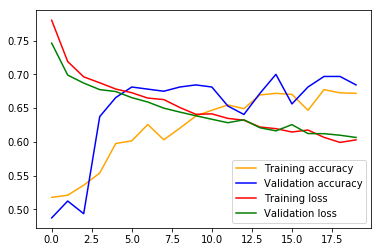

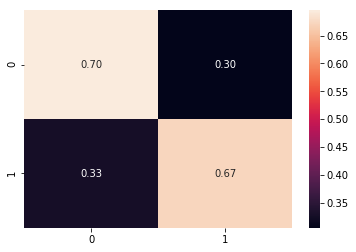

             precision    recall  f1-score   support

    Finding       0.69      0.70      0.69       164
     Normal       0.68      0.67      0.68       156

avg / total       0.68      0.68      0.68       320

INFO:tensorflow:Assets written to: model/abnormal/vgg19/AbNormal_3/assets
number of sample Train: 1280
number of sample Test: 400
number of sample Val: 320
Average test accuracy:  0.6382031
Average test loss:  0.6425350326299667


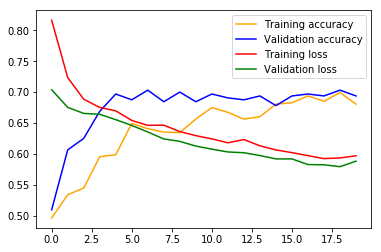

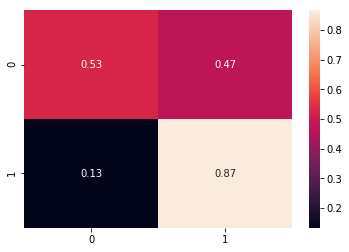

             precision    recall  f1-score   support

    Finding       0.80      0.53      0.64       163
     Normal       0.64      0.87      0.74       157

avg / total       0.72      0.69      0.69       320

INFO:tensorflow:Assets written to: model/abnormal/vgg19/AbNormal_4/assets


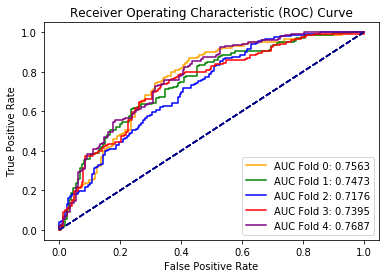

In [42]:
idk(disease_images, normal_images,"AbNormal")

In [29]:
from sklearn.model_selection import KFold
def idk16(other, normal,text) :
    k = 0
    # set to 5 folds
    box_tpr = []
    box_fpr = []
    box_acc = []
    #Set Test
    data = []
    label = []
    index = 0
    for i in range(5):
        for count in range(int(normal.shape[0]/5)):
            data.append(normal[index+count])
            label.append(1)
#             print(index+count)
        for count in range(int(other.shape[0]/5)):
            data.append(other[index+count])
            label.append(0)
        index+=int(normal.shape[0]/5)
    data = np.array(data)
    label = np.array(label)
    train_data, X_test, label_train, y_test = train_test_split(data, label, test_size=0.2)
#     X_test_n, y_test_n = incre(X_test,y_test)
    n_classes = 2
    y_test = keras.utils.to_categorical(y_test, n_classes)
    kf = KFold(n_splits=5)
    for train, val in kf.split(train_data):
        X_train = train_data[train]
        X_val = train_data[val]
        y_train = label_train[train]
        y_val = label_train[val]
        
#         X_train_n, y_train_n = incre(X_train,y_train)
#         X_val_n, y_val_n = incre(X_val,y_val)
        #class
        y_train = keras.utils.to_categorical(y_train, n_classes)
        y_val = keras.utils.to_categorical(y_val, n_classes)
#         print(y_test)
        
        print("number of sample Train: {}".format(len(X_train)))
        print("number of sample Test: {}".format(len(X_test)))
        print("number of sample Val: {}".format(len(X_val)))
        
        
        recv_fpr,recv_tpr,recv_acc = cnn_model(X_train,y_train,X_test,y_test,X_val,y_val,k,text)
        box_fpr.append(recv_fpr)
        box_tpr.append(recv_tpr)
        box_acc.append(recv_acc)
        k += 1
        
        #only one round
#         if k == 1: break
        
    # ROC
    roc(box_fpr,box_tpr,box_acc,k)

## Mark Temp VGG16

number of sample Train: 1280
number of sample Test: 400
number of sample Val: 320
Average test accuracy:  0.6256641
Average test loss:  0.6570841646194457


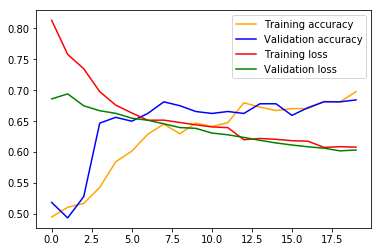

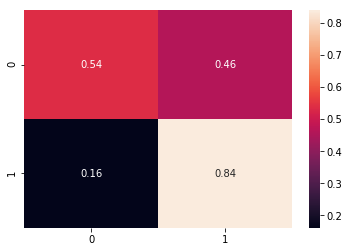

             precision    recall  f1-score   support

    Finding       0.78      0.54      0.64       165
     Normal       0.63      0.84      0.72       155

avg / total       0.71      0.68      0.68       320

INFO:tensorflow:Assets written to: model/abnormal/vgg16/AbNormal_0/assets
number of sample Train: 1280
number of sample Test: 400
number of sample Val: 320
Average test accuracy:  0.6314844
Average test loss:  0.6440557891130447


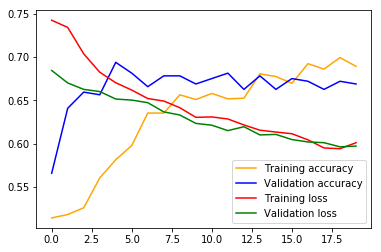

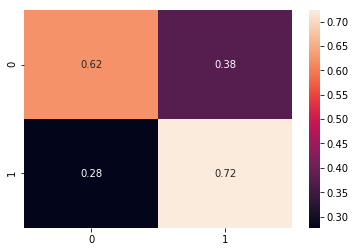

             precision    recall  f1-score   support

    Finding       0.72      0.62      0.67       172
     Normal       0.62      0.72      0.67       148

avg / total       0.68      0.67      0.67       320

INFO:tensorflow:Assets written to: model/abnormal/vgg16/AbNormal_1/assets
number of sample Train: 1280
number of sample Test: 400
number of sample Val: 320
Average test accuracy:  0.6311718
Average test loss:  0.640951795578003


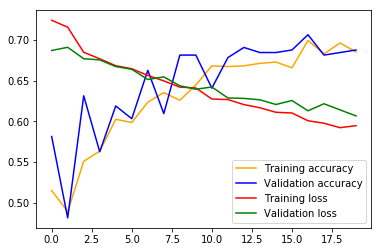

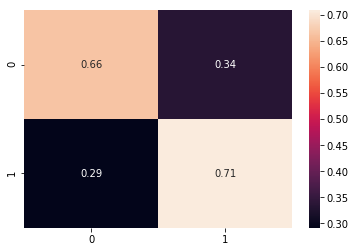

             precision    recall  f1-score   support

    Finding       0.67      0.66      0.67       152
     Normal       0.70      0.71      0.70       168

avg / total       0.69      0.69      0.69       320

INFO:tensorflow:Assets written to: model/abnormal/vgg16/AbNormal_2/assets
number of sample Train: 1280
number of sample Test: 400
number of sample Val: 320
Average test accuracy:  0.61996096
Average test loss:  0.6536039793491362


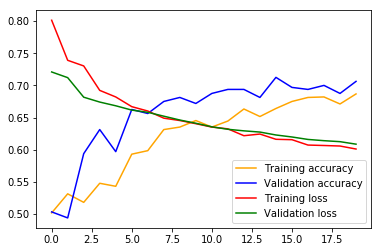

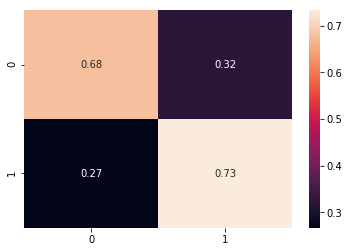

             precision    recall  f1-score   support

    Finding       0.72      0.68      0.70       159
     Normal       0.70      0.73      0.72       161

avg / total       0.71      0.71      0.71       320

INFO:tensorflow:Assets written to: model/abnormal/vgg16/AbNormal_3/assets
number of sample Train: 1280
number of sample Test: 400
number of sample Val: 320
Average test accuracy:  0.6270703
Average test loss:  0.6464757764339446


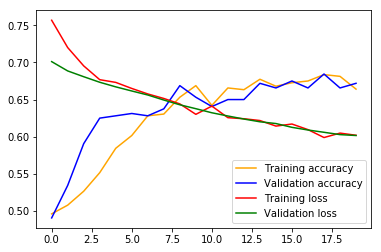

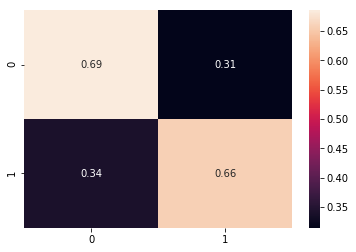

             precision    recall  f1-score   support

    Finding       0.67      0.69      0.68       162
     Normal       0.67      0.66      0.66       158

avg / total       0.67      0.67      0.67       320

INFO:tensorflow:Assets written to: model/abnormal/vgg16/AbNormal_4/assets


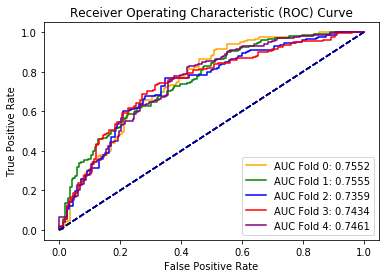

In [30]:
idk16(disease_images, normal_images,"AbNormal")

number of sample Train: 1280
number of sample Test: 400
number of sample Val: 320
Average test accuracy:  0.6442578
Average test loss:  0.6354673367738723


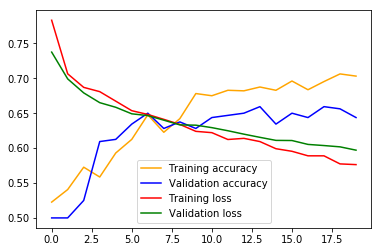

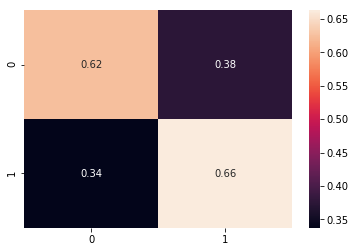

             precision    recall  f1-score   support

    Finding       0.65      0.62      0.64       160
     Normal       0.64      0.66      0.65       160

avg / total       0.64      0.64      0.64       320

INFO:tensorflow:Assets written to: model/abnormal/vgg16/AbNormal_0/assets
number of sample Train: 1280
number of sample Test: 400
number of sample Val: 320
Average test accuracy:  0.6091407
Average test loss:  0.6591257029771804


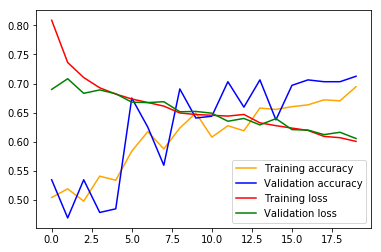

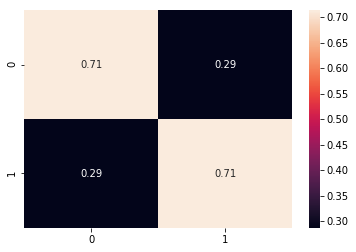

             precision    recall  f1-score   support

    Finding       0.69      0.71      0.70       150
     Normal       0.74      0.71      0.72       170

avg / total       0.71      0.71      0.71       320

INFO:tensorflow:Assets written to: model/abnormal/vgg16/AbNormal_1/assets
number of sample Train: 1280
number of sample Test: 400
number of sample Val: 320
Average test accuracy:  0.6450391
Average test loss:  0.6366086572408676


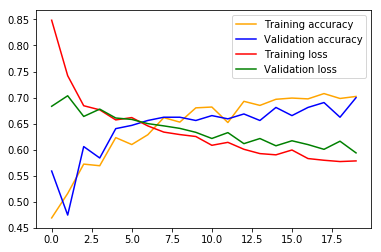

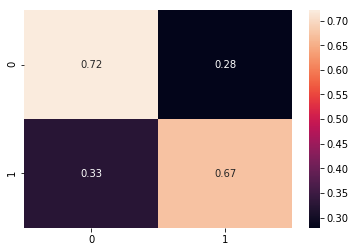

             precision    recall  f1-score   support

    Finding       0.74      0.72      0.73       179
     Normal       0.66      0.67      0.66       141

avg / total       0.70      0.70      0.70       320

INFO:tensorflow:Assets written to: model/abnormal/vgg16/AbNormal_2/assets
number of sample Train: 1280
number of sample Test: 400
number of sample Val: 320
Average test accuracy:  0.6355468
Average test loss:  0.652144792675972


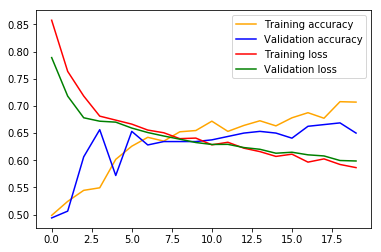

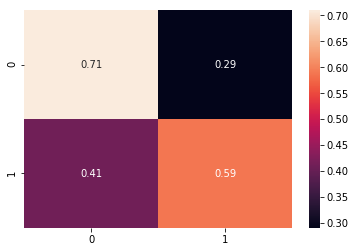

             precision    recall  f1-score   support

    Finding       0.64      0.71      0.67       162
     Normal       0.66      0.59      0.62       158

avg / total       0.65      0.65      0.65       320

INFO:tensorflow:Assets written to: model/abnormal/vgg16/AbNormal_3/assets
number of sample Train: 1280
number of sample Test: 400
number of sample Val: 320
Average test accuracy:  0.623711
Average test loss:  0.6474094790220261


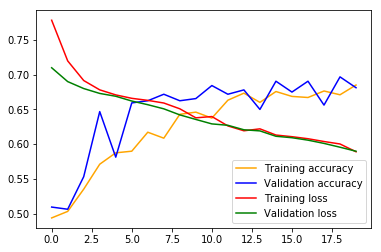

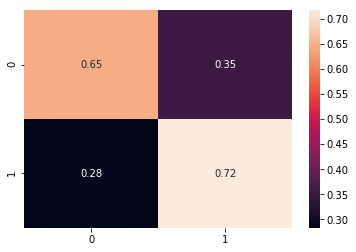

             precision    recall  f1-score   support

    Finding       0.70      0.65      0.67       161
     Normal       0.67      0.72      0.69       159

avg / total       0.68      0.68      0.68       320

INFO:tensorflow:Assets written to: model/abnormal/vgg16/AbNormal_4/assets


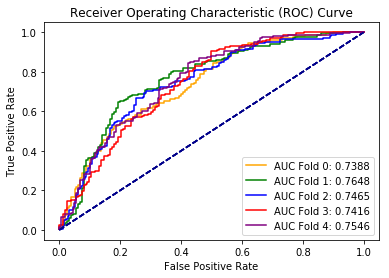

In [43]:
idk16(disease_images, normal_images,"AbNormal")